In [1]:
import gtfs_kit as gk
from pathlib import Path
from hmr_utils import *
import pandas as pd
import os
from tqdm import tqdm
data_folder = '/Users/alfredo.leon/Desktop/DataMiningProject/Project Data-20221021/'
path = Path(data_folder+"gtfs3Sept.zip")
feed = (gk.read_feed(path, dist_units='km'))
%matplotlib inline

First reduce the data from the csvs

In [2]:
recompute_reduced = False
if recompute_reduced:
    files = [_file for _file in os.listdir(f"{data_folder}csvs/") if ".csv" in _file]
    route_short_names = ['71', '34', '57', '95']
    route_ids = [get_route_id_from_route_short_name(route_short_name, feed.routes) 
                 for route_short_name in route_short_names]
    for _file in tqdm(files):
        for route in route_short_names:
            df = retrieve_route_data_at_stops_from_csv(
                route_short_name=int(route), 
                input_file=f'{data_folder}csvs/{_file}', 
                feed=feed, distance_from_point=10.0
            )
            df.to_csv(f'{data_folder}csvs/reduced/reduced_route{route}_{_file}', index=False)

In [3]:
reduced_csvs_folder = '/Users/alfredo.leon/Desktop/DataMiningProject/Project Data-20221021/csvs/reduced/'
if recompute_reduced:
    dfs = []
    
    for _file in os.listdir(reduced_csvs_folder):
        df = pd.read_csv(f'{reduced_csvs_folder}{_file}', index_col=None)
        dfs.append(df)
    reduced_read_data = pd.concat(dfs)

    reduced_read_data.to_parquet(f'{reduced_csvs_folder}reduced_all', engine='fastparquet', 
                                 compression='gzip', index=False, partition_cols=['lineID', 'stop_id'])
else:
    reduced_read_data = pd.read_parquet(f'{reduced_csvs_folder}reduced_all')
print(reduced_read_data.shape)
reduced_read_data['time'] = pd.to_datetime(reduced_read_data['time'])

(458920, 13)


In [4]:
reduced_read_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458920 entries, 0 to 458919
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamp          458920 non-null  int64         
 1   directionID        458920 non-null  int64         
 2   distancefromPoint  458920 non-null  float64       
 3   time               458920 non-null  datetime64[ns]
 4   year               458920 non-null  int64         
 5   month              458920 non-null  int64         
 6   day                458920 non-null  int64         
 7   hour               458920 non-null  int64         
 8   minute             458920 non-null  int64         
 9   second             458920 non-null  int64         
 10  stop_name          458920 non-null  object        
 11  lineID             458920 non-null  category      
 12  stop_id            458920 non-null  category      
dtypes: category(2), datetime64[ns](1), float64(1

In [5]:
def get_real_headways_from_reduced_data(reduced_data: pd.DataFrame):
    grouped = reduced_data.groupby(by=['lineID', 'directionID', 'year', 'month', 'day', 'stop_id'])
    groups = []
    for idx, group in grouped:
        group = group.sort_values(by='timestamp')
        group['headway'] = group['time'] - group['time'].shift(1)
        groups.append(group)
    return pd.concat(groups)

In [6]:
groups = get_real_headways_from_reduced_data(reduced_read_data)
groups

,timestamp,directionID,distancefromPoint,time,year,month,day,hour,minute,second,stop_name,lineID,stop_id,headway
370,1631895658451,1233,0.0,2021-09-17 16:20:58.451,2021,9,17,16,20,58,LUXEMBOURG,34,1233,NaT
155,1630915202427,1713,0.0,2021-09-06 08:00:02.427,2021,9,6,8,0,2,LUXEMBOURG,34,1233,NaT
200,1630967664052,1713,0.0,2021-09-06 22:34:24.052,2021,9,6,22,34,24,LUXEMBOURG,34,1233,0 days 14:34:21.625000
4783,1630967756316,1713,0.0,2021-09-06 22:35:56.316,2021,9,6,22,35,56,IDALIE,34,1706,NaT
7012,1630914886924,1713,0.0,2021-09-06 07:54:46.924,2021,9,6,7,54,46,LA CHASSE,34,1713,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439395,1632240045826,7104,4.0,2021-09-21 16:00:45.826,2021,9,21,16,0,45,GERMOIR,95,4366,0 days 00:04:45.290000
439396,1632240078697,7104,4.0,2021-09-21 16:01:18.697,2021,9,21,16,1,18,GERMOIR,95,4366,0 days 00:00:32.871000
439397,1632240206391,7104,4.0,2021-09-21 16:03:26.391,2021,9,21,16,3,26,GERMOIR,95,4366,0 days 00:02:07.694000
439398,1632240236600,7104,7.0,2021-09-21 16:03:56.600,2021,9,21,16,3,56,GERMOIR,95,4366,0 days 00:00:30.209000


Once we have the reduced data, we can then calculate the real headways per route.

In [63]:
from datetime import datetime
import numpy as np

def gtfs_timetable_for_punctuality(route_id, stop_id, date, feed: gk.Feed, 
                                   cols_to_return=[
                                       'arrival_time', 'departure_time', 'stop_id', 
                                       'stop_name', 'direction_id', 'route_id', 
                                       'trip_headsign', 'date', 'expected_headway'],
                                  by_index='arrival_time'):
    date_info = datetime.strptime(date, "%Y%m%d")
    timetable = gk.build_route_timetable(feed, route_id, [date])
    timetable = timetable.loc[(timetable.stop_id==stop_id)].merge(feed.stops)
    timetable[by_index] = timetable['date'] + " " + timetable[by_index]
    timetable[by_index] = pd.to_datetime(timetable[by_index], errors='coerce', format="%Y%m%d %H:%M:%S")
    timetable['expected_headway'] = (timetable[by_index] - timetable[by_index].shift(1)).dt.total_seconds()
    #timetable[by_index] = timetable[by_index].dt.time
    timetable = timetable.set_index(by_index, drop=False)
    timetable.index = pd.to_datetime(timetable.index)
    return timetable[cols_to_return]

def real_timetable_for_punctuality(route_id, stop_id, date, real_data_df: pd.DataFrame, feed: gk.Feed,
                                  cols_to_return=['time', 'actual_stop_id', 'actual_stop_name', 
                                                  'lineID', 'stop_id', 'date']):
    route_short_name = get_route_name_from_route_id(route_id, feed.routes)
    #print(route_short_name, date)
    dateparts = real_data_df[['day','month','year']]
    real_data_df['date'] = pd.to_datetime(dateparts)
    real_data_df['date'] = real_data_df['date'].apply(lambda x: x.strftime("%Y%m%d"))
    #print(date, real_data_df['date'])
    timetable:pd.DataFrame = real_data_df.loc[
        (real_data_df.lineID == int(route_short_name)) & 
        (real_data_df.stop_id == int(stop_id)) &
        (real_data_df.date == date)
    ]
    timetable.rename(columns={"stop_id": "actual_stop_id", "directionID": "stop_id", "stop_name": "actual_stop_name"}, inplace=True)
    timetable.stop_id = timetable.stop_id.astype(str)
    stops = feed.stops
    stops['stop_id'] = stops['stop_id'].astype(str)
    #print(feed.stops.info())
    #print(timetable[cols_to_return])
    timetable = timetable[cols_to_return].merge(stops[['stop_id', 'stop_name']], on='stop_id')
    timetable.rename(columns={"stop_id": "direction_stop_id", 'stop_name': 'trip_headsign'}, inplace=True)
    timetable = timetable.set_index('time', drop=False)
    timetable.index = pd.to_datetime(timetable.index)
    timetable['real_headway'] = (timetable['time'] - timetable['time'].shift(1)).dt.total_seconds()
    #timetable['trip_headsign'] = timetable['directionID'].apply(
    #    lambda x: feed.stops.loc[feed.stops.stop_id == x].iloc[0]['stop_name']
    #)
    return timetable
    

In [64]:
route_71_cim = gtfs_timetable_for_punctuality('65', '3558', '20210908', feed)

In [69]:
route_71_cim = route_71_cim['2021-09-08 08:00:00': '2021-09-08 09:00:00']

In [70]:
route_71_cim_real = real_timetable_for_punctuality('65', '3558', '20210908', groups, feed)
route_71_cim_real = route_71_cim_real['2021-09-08 08:00:00.000': '2021-09-08 09:00:00.000'].head(20)

In [77]:
route_71_cim

,arrival_time,departure_time,stop_id,stop_name,direction_id,route_id,trip_headsign,date,expected_headway
arrival_time,,,,,,,,,
2021-09-08 08:04:00,2021-09-08 08:04:00,08:04:00,3558,CIM. D'IXELLES,1,65,DE BROUCKERE,20210908,300.0
2021-09-08 08:09:00,2021-09-08 08:09:00,08:09:00,3558,CIM. D'IXELLES,1,65,DE BROUCKERE,20210908,300.0
2021-09-08 08:14:00,2021-09-08 08:14:00,08:14:00,3558,CIM. D'IXELLES,1,65,DE BROUCKERE,20210908,300.0
2021-09-08 08:19:00,2021-09-08 08:19:00,08:19:00,3558,CIM. D'IXELLES,1,65,DE BROUCKERE,20210908,300.0
2021-09-08 08:24:00,2021-09-08 08:24:00,08:24:00,3558,CIM. D'IXELLES,1,65,DE BROUCKERE,20210908,300.0
2021-09-08 08:30:00,2021-09-08 08:30:00,08:30:00,3558,CIM. D'IXELLES,1,65,DE BROUCKERE,20210908,360.0
2021-09-08 08:35:00,2021-09-08 08:35:00,08:35:00,3558,CIM. D'IXELLES,1,65,DE BROUCKERE,20210908,300.0
2021-09-08 08:40:00,2021-09-08 08:40:00,08:40:00,3558,CIM. D'IXELLES,1,65,DE BROUCKERE,20210908,300.0
2021-09-08 08:45:00,2021-09-08 08:45:00,08:45:00,3558,CIM. D'IXELLES,1,65,DE BROUCKERE,20210908,300.0


In [85]:
route_71_cim_real

,time,actual_stop_id,actual_stop_name,lineID,direction_stop_id,date,trip_headsign,real_headway
time,,,,,,,,
2021-09-08 08:02:57.829,2021-09-08 08:02:57.829,3558,CIM. D'IXELLES,71,2596,20210908,DE BROUCKERE,513.140
2021-09-08 08:05:39.828,2021-09-08 08:05:39.828,3558,CIM. D'IXELLES,71,2596,20210908,DE BROUCKERE,161.999
2021-09-08 08:10:27.169,2021-09-08 08:10:27.169,3558,CIM. D'IXELLES,71,2596,20210908,DE BROUCKERE,287.341
2021-09-08 08:10:58.913,2021-09-08 08:10:58.913,3558,CIM. D'IXELLES,71,2596,20210908,DE BROUCKERE,31.744
2021-09-08 08:20:38.714,2021-09-08 08:20:38.714,3558,CIM. D'IXELLES,71,2596,20210908,DE BROUCKERE,579.801
2021-09-08 08:31:55.143,2021-09-08 08:31:55.143,3558,CIM. D'IXELLES,71,2596,20210908,DE BROUCKERE,676.429
2021-09-08 08:32:26.520,2021-09-08 08:32:26.520,3558,CIM. D'IXELLES,71,2596,20210908,DE BROUCKERE,31.377
2021-09-08 08:36:43.140,2021-09-08 08:36:43.140,3558,CIM. D'IXELLES,71,2596,20210908,DE BROUCKERE,256.620
2021-09-08 08:46:15.571,2021-09-08 08:46:15.571,3558,CIM. D'IXELLES,71,2596,20210908,DE BROUCKERE,572.431


In [120]:
from tslearn.utils import to_time_series
from tslearn.metrics import dtw_path

gtfs_ts = to_time_series(route_71_cim.index.asi8)
real_ts = to_time_series(route_71_cim_real.index.asi8)

print(gtfs_ts)
print(real_ts)

path, score = dtw_path(gtfs_ts, real_ts)
print(score)

[[1.63108824e+18]
 [1.63108854e+18]
 [1.63108884e+18]
 [1.63108914e+18]
 [1.63108944e+18]
 [1.63108980e+18]
 [1.63109010e+18]
 [1.63109040e+18]
 [1.63109070e+18]
 [1.63109100e+18]
 [1.63109130e+18]
 [1.63109160e+18]]
[[1.63108818e+18]
 [1.63108834e+18]
 [1.63108863e+18]
 [1.63108866e+18]
 [1.63108924e+18]
 [1.63108992e+18]
 [1.63108995e+18]
 [1.63109020e+18]
 [1.63109078e+18]
 [1.63109113e+18]]
668979231211.8918


In [117]:
from dtw import dtw

Text(0.5, 1.0, 'Route 71 Sample Punctuality Measure using DTW from 8-9 am at Cim. Ixelles.')

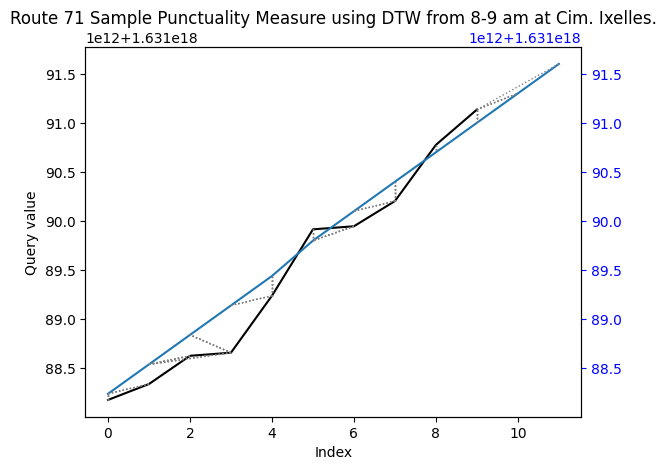

In [123]:
alignment = dtw(real_ts, gtfs_ts, keep_internals=True)
alignment.plot(type="twoway", offset=-2)
plt.title("Route 71 Sample Punctuality Measure using DTW from 8-9 am at Cim. Ixelles.")

In [126]:
def get_dtw_for_punctuality(route_id, stop_id, date='20210908', from_hour='2021-09-08 08:00:00', 
                            to_hour='2021-09-08 23:59:00', feed=None, reduced_data=None):
    gtfs_timetable = gtfs_timetable_for_punctuality(route_id, stop_id, date, feed)
    real_timetable = real_timetable_for_punctuality(route_id, stop_id, date, reduced_data, feed)
    gtfs_timetable = gtfs_timetable[from_hour: to_hour]
    real_timetable = real_timetable[from_hour: to_hour]
    gtfs_ts = to_time_series(gtfs_timetable.index.asi8)
    real_ts = to_time_series(real_timetablel.index.asi8)
    path, score = dtw_path(gtfs_ts, real_ts)
    alignment = dtw(real_ts, gtfs_ts, keep_internals=True)
    alignment.plot(type="twoway", offset=-2)

In [ ]:
route_34_dtw = 